<h1>Automatic Image Caption generator using Deep Learning</h1><br>
<p align="right">21BCE095 Jay Pandya<br>21BCE090 Isha Khakhar<BR>21BCE124 Kiran Kher<BR>21BCE119 Meet Khunt</p>

In [ ]:
from google.colab import drive # To link drive
drive.mount('/content/drive')

<h3>Importing Modules

In [ ]:
#pip install "tensorflow<2.11"
#pip install keras
#!pip install tqdm

import os #file handling.
import pickle #storing numpy features(img data).
import numpy as np #for nimpy array and math related functions.
from tqdm.notebook import tqdm # UI for processed data, for loading bar animation.
#VGG16 is a pre-trained convolutional neural network (CNN) used for Image classification tasks.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #deep convolutional neural network commonly used for image feature extraction in computer vision tasks
from tensorflow.keras.preprocessing.image import load_img, img_to_array #functions for loading images and converting them to NumPy arrays
from tensorflow.keras.preprocessing.text import Tokenizer #used for text preprocessing, including tokenization.
from tensorflow.keras.preprocessing.sequence import pad_sequences # make all input sequences the same length.
from tensorflow.keras.models import Model #used for defining and training neural network models.
from tensorflow.keras.utils import to_categorical, plot_model #for converting labels to categorical format and for plotting Keras models.
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add #imports various layers from Keras, which can be used to build a neural network

In [ ]:
BASE_DIR = '/content/drive/MyDrive/ML/images'
WORKING_DIR = '/content/drive/MyDrive/ML'

<h3>Extract Image Features</h3>

In [ ]:
#load vgg16 model
model = VGG16() #VGG16 is a pre-trained convolutional neural network (CNN)
#restructure model
"""The VGG16 model, by default, is a complete CNN architecture for image classification. However,
for image captioning, you typically don't need the final classification layer (which is the last layer).
So, you create a new model that takes the same inputs but outputs the activations of the second-to-last layer of the VGG16 model.
 This is done to extract meaningful image features that can be used in the captioning process."""
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#summerize
print(model.summary())
"""By removing the final classification layer, you're essentially repurposing VGG16 as a feature extractor for image captioning."""

In [ ]:
#extract features from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    #convert img to numpy array
    image = img_to_array(image)
    #reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    #store features
    features[image_id] = feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))
!nvidia-smi

In [ ]:

# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

<h3>Load Caption

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:

# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',') #caption format : img_ID.jpg , Caption....
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption) #

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

<h3>Preprocess TEXT

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '') # remove any characters that are not alphabetic
            # delete additional spaces
            caption = caption.replace('\s+', ' ') # replace one or more consecutive whitespace characters with a single space
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
before preprocess of text
mapping['1000268201_693b08cb0e']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
after preprocess of text
mapping['1000268201_693b08cb0e']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

In [ ]:
all_captions[:10]

In [ ]:
# tokenize the text, process of splitting text into individual words or tokens.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
#vocab_size

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

<h2>Train test split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list() #image features, input sequences, and output sequences.
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                # two dogs are playing
                #x two  y dogs
                #x two dogs  y are

                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

<h3>Create Model

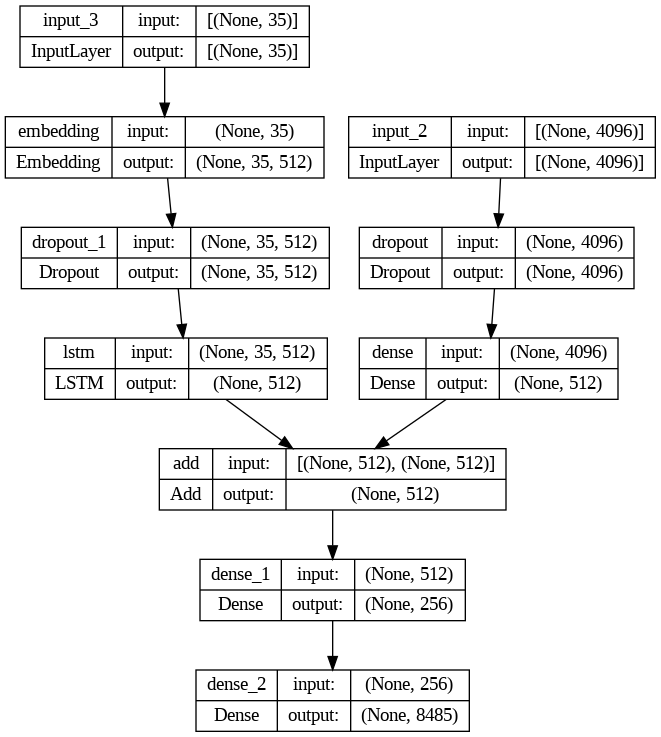

In [ ]:
# model Creation
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)# A dropout layer is added to help prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training.
fe2 = Dense(512, activation='relu')(fe1)#A dense (fully connected) layer
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2) #embedding layer is used to convert the integer-encoded words into dense vectors of fixed size.
se2 = Dropout(0.4)(se1)#Another dropout layer is added for regularization.
se3 = LSTM(512)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

<h2>Train Model

In [ ]:
# train the model
epo = 40
batch_size = 32
steps = len(train) // batch_size
# create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# fit for one epoch
model.fit(generator, epochs=epo, steps_per_epoch=steps, verbose=1 )

In [ ]:
# save the model
model.save(WORKING_DIR+'/BEST_model.h5')

In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model(WORKING_DIR+'/BEST_model.h5')

<h3>Generate caption

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():#tokenizer.word_index attribute is a dictionary that maps words to their corresponding integer indices.
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

<h2>Performance Anaysis

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

"""The BLEU scores provide an evaluation of the quality of the generated captions by comparing them to the actual captions.
A higher BLEU score indicates better quality. """

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.495431
BLEU-2: 0.272470


<h3>Visualize the Result

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown dog runs for white and black dog on the grass endseq
startseq white dog and brown dog play in the grass endseq
startseq the dogs are in the field playing endseq
startseq two dogs playing on grass endseq
startseq two dogs play together endseq
--------------------Predicted--------------------
startseq two dogs one brown and one black playing with each other endseq


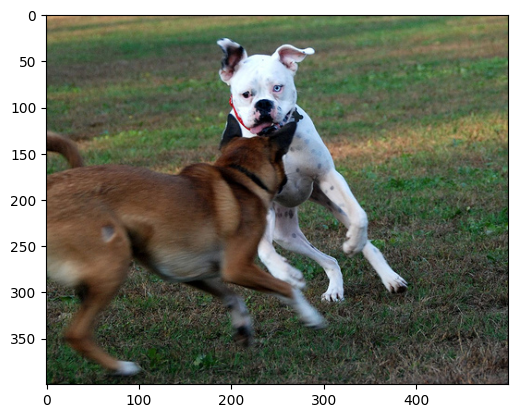

In [ ]:
generate_caption("1778020185_1d44c04dae.jpg")

---------------------Actual---------------------
startseq boy in red and girl pink are walking through low cut field endseq
startseq the little boy and little girl are walking side by side endseq
startseq two small children walk away in field endseq
startseq two small children walking in field endseq
startseq two young children are walking across an open field endseq
--------------------Predicted--------------------
startseq two children playing soccer endseq


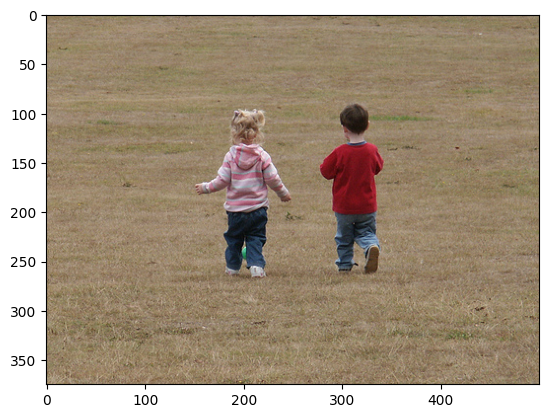

In [ ]:
generate_caption("438639005_208bc59b0b.jpg")

<h1>Test with real images

In [ ]:
def crt_lk(l):
    l=list(l)

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

'startseq black and white dog is running through the water endseq'

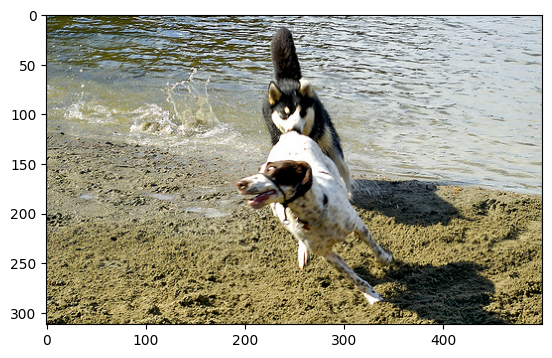

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = "/content/drive/MyDrive/ML/images/Images/460478198_83039f2593.jpg"
image = Image.open(image_path)
plt.imshow(image)
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

In [ ]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the pre-trained VGG16 model for feature extraction
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

# Define your image captioning model, tokenizer, and max_length here
# (Assuming you have these already defined)

# Initialize the video capture object (use 0 for webcam or provide a video file path)
try:
    video_capture = cv2.VideoCapture(0)
except Exception as e:
    print("Error initializing video capture:", str(e))
    exit()

while True:
    try:
        # Capture a frame
        ret, frame = video_capture.read()

        if not ret:
            print("Error capturing frame.")
            break

        # Preprocess the frame
        fr = frame
        frame = cv2.resize(frame, (224, 224))  # Resize frame to match VGG16 input size
        frame = img_to_array(frame)
        frame = frame.reshape((1, frame.shape[0], frame.shape[1], frame.shape[2]))
        frame = preprocess_input(frame)

        # Extract features from the frame using VGG16
        fet = vgg_model.predict(frame, verbose=0)

        # Generate captions for the frame
        caption = predict_caption(model, fet, tokenizer, max_length)
        #print(caption)
        # Display the frame with the caption
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (0, 0, 0)  # Black
        font_thickness = 2
        text_position = (10, 30)
        cv2.putText(fr, caption, text_position, font, font_scale, font_color, font_thickness)
        cv2.imshow("Real-time Captioning", fr)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    except Exception as e:
        print("Error processing frame:", str(e))
        video_capture.release()
        break

# Release the video capture object and close all OpenCV windows
video_capture.release()
cv2.destroyAllWindows()

Error capturing frame.
